In [1]:
import pandas as pd
from pandas import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
%matplotlib inline
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error

In [2]:
# test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')
# test=pd.read_csv('/home/atif/dataset_26_april_3.csv')
test=pd.read_csv('E:/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

In [3]:
import datetime
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

C:\Users\atif\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [6]:
test_new = test_new.set_index('dateTime') # make dataTime column as index of the dataframe test_new

In [84]:
univariate_column_label=['AEDAHO_T9_V2']
univariate_data=test_new.iloc[1000:12000][univariate_column_label]
univariate_data=univariate_data.loc[::-1]

In [85]:
univariate_data.head()

,AEDAHO_T9_V2
dateTime,
2019-03-31 00:21:00,65.738268
2019-03-31 00:22:00,66.053339
2019-03-31 00:23:00,66.451354
2019-03-31 00:24:00,66.211389
2019-03-31 00:25:00,65.839185


shape of univariate_data:  (11000, 1)


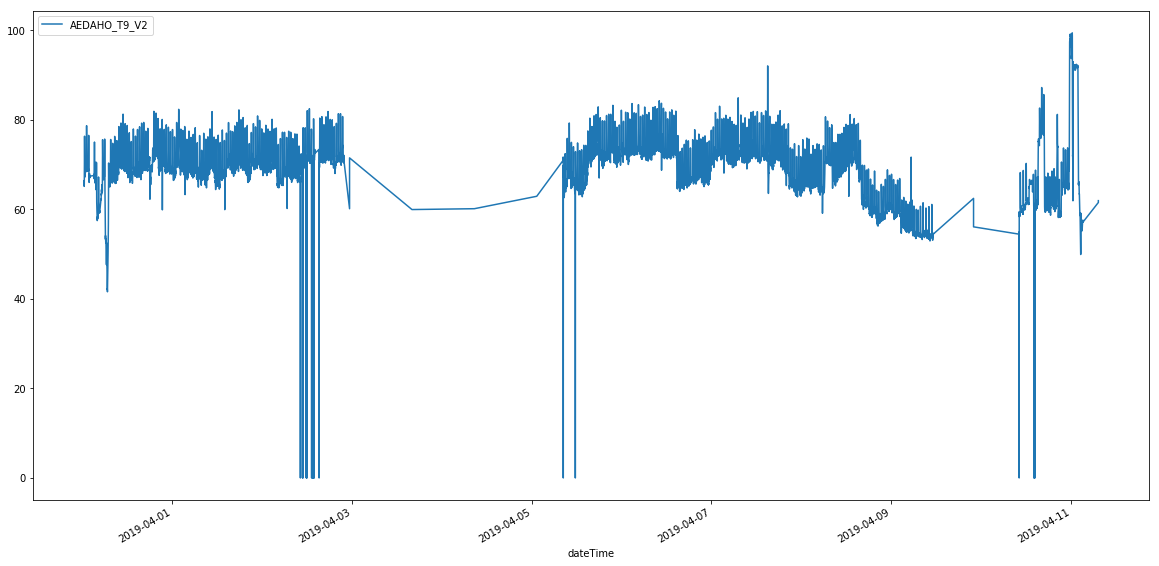

In [86]:
from matplotlib.pylab import rcParams
print('shape of univariate_data: ',univariate_data.shape)
univariate_data.plot()
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [87]:
# from numpy import nan
# univariate_data_drop_zero= univariate_data.replace(0,nan)
# univariate_data_drop_zero= univariate_data_drop_zero.dropna(how='any',axis=0)

# univariate_data_drop_zero.plot()
# plt.show()

In [88]:
# dataset=univariate_data_drop_zero.values
# print(type(dataset))
# # print(dataset)
# print('length of dataset: ',len(dataset))

# check for zero value

In [89]:
# zero_value=univariate_data.columns[univariate_data.isnull().any()]
# univariate_data[zero_value].isnull().sum()

for idx,val in enumerate(list(univariate_data.columns)):
    count=1
    for i, j in univariate_data.iterrows():
        for k in j:
            if k==0:
                count+=1
                print(i,'\t\t',k)

2019-04-02 10:12:00 		 0.0
2019-04-02 10:45:00 		 0.0
2019-04-02 10:46:00 		 0.0
2019-04-02 10:54:00 		 0.0
2019-04-02 11:48:00 		 0.0
2019-04-02 11:50:00 		 0.0
2019-04-02 11:57:00 		 0.0
2019-04-02 11:58:00 		 0.0
2019-04-02 13:12:00 		 0.0
2019-04-02 13:23:00 		 0.0
2019-04-02 13:28:00 		 0.0
2019-04-02 13:33:00 		 0.0
2019-04-02 13:41:00 		 0.0
2019-04-02 13:47:00 		 0.0
2019-04-02 13:51:00 		 0.0
2019-04-02 15:11:00 		 0.0
2019-04-02 15:12:00 		 0.0
2019-04-05 08:25:00 		 0.0
2019-04-05 11:38:00 		 0.0
2019-04-10 10:11:00 		 0.0
2019-04-10 14:09:00 		 0.0
2019-04-10 14:12:00 		 0.0
2019-04-10 14:13:00 		 0.0
2019-04-10 14:14:00 		 0.0
2019-04-10 14:19:00 		 0.0
2019-04-10 14:22:00 		 0.0


In [90]:
zero_val=univariate_data.loc[univariate_data['AEDAHO_T9_V2']==0]
print(zero_val.size)

26


# dropping zero

In [94]:
from numpy import nan
univariate_data_drop_zero = univariate_data.replace(0,nan)
univariate_data_drop_zero = univariate_data_drop_zero.dropna(how='any',axis=0)
print('shape: ',univariate_data_drop_zero.shape,' size: ',univariate_data_drop_zero.size)

shape:  (10974, 1)  size:  10974


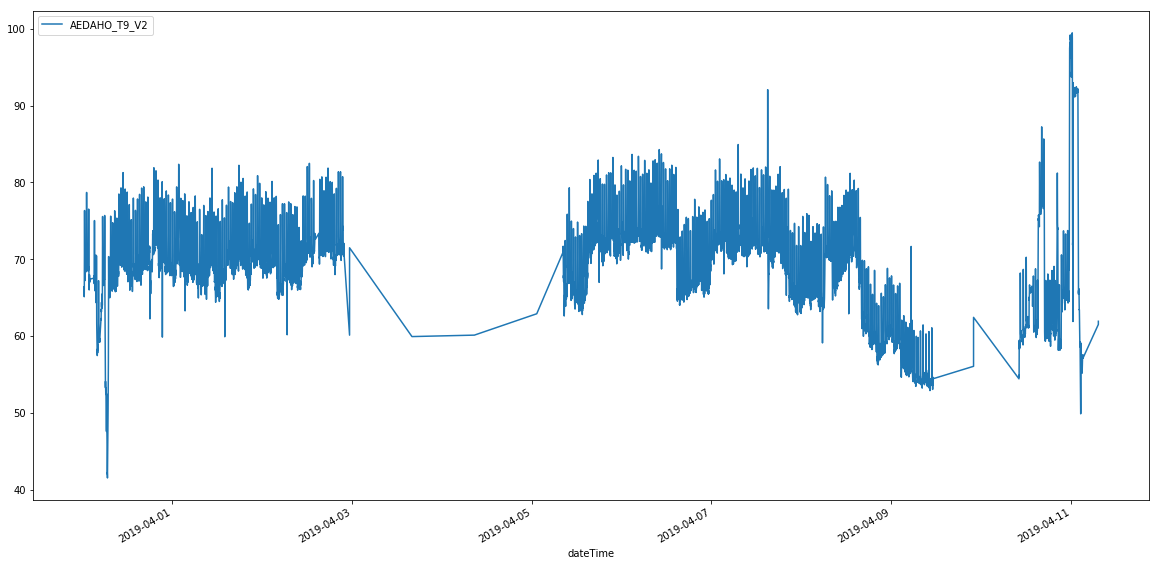

In [95]:
univariate_data_drop_zero.plot()
plt.show()

In [96]:
print('shape: ',univariate_data.shape,' size: ',univariate_data.size)

shape:  (11000, 1)  size:  11000


# replace zero value with the mean value

In [91]:
univariate_mean = univariate_data.mean()
univariate_data_mean= univariate_data.replace(0,univariate_mean)
print('univariate_data_mean : ',univariate_data_mean.head())

univariate_data_mean :                       AEDAHO_T9_V2
dateTime                         
2019-03-31 00:21:00     65.738268
2019-03-31 00:22:00     66.053339
2019-03-31 00:23:00     66.451354
2019-03-31 00:24:00     66.211389
2019-03-31 00:25:00     65.839185


In [92]:
zero_val_now=univariate_data_mean.loc[univariate_data_mean['AEDAHO_T9_V2']==0]
print(zero_val_now.size)

0


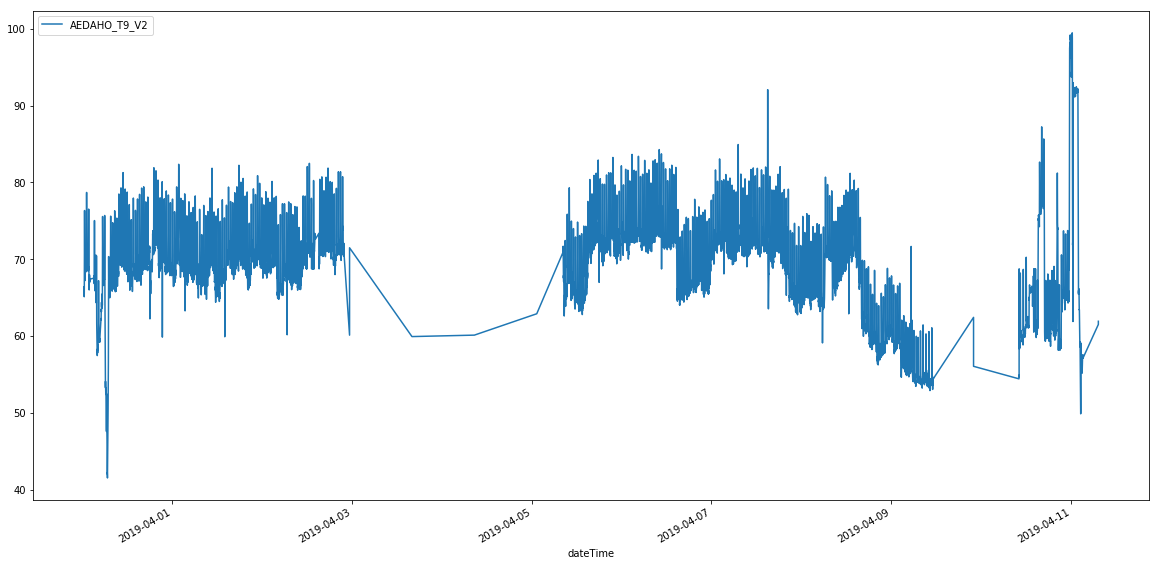

In [93]:
univariate_data_mean.plot()
plt.show()

In [72]:
dataset=univariate_data_mean.values
NumberOfElements=int(len(dataset)*0.9)
print(NumberOfElements)
print(len(dataset))

4500
5000


In [73]:
train_set=dataset[0:NumberOfElements]
test_set=dataset[NumberOfElements:len(dataset)]

test_set_1=dataset[4949:len(dataset)]

In [75]:
print('Train data shape:',train_set.shape,'\tsize:',train_set.size)
print('Test data shape:',test_set.shape,'\tsize:',test_set.size)
print('Test data 1 shape:',test_set_1.shape,'\tsize:',test_set_1.size)

Train data shape: (4500, 1) 	size: 4500
Test data shape: (500, 1) 	size: 500
Test data 1 shape: (51, 1) 	size: 51


In [76]:
Actual = [x for x in train_set]
Predictions = list()

In [77]:
#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    print('from function screaming')
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
#     save_model=model_fit.save('model_22.pkl')
    prediction = model_fit.forecast()[0]
    save_model=model_fit.save('model_22.pkl')
    return prediction,save_model

In [78]:
count_1=1
for timepoint in range(len(test_set_1)):
    print('I am in for loop')
    ActualValue =  test_set[timepoint]
    #forcast value
    Prediction,save_model_1 = StartARIMAForecasting(Actual, 2,1,2) 
    print('count=%d, Actual=%f, Predicted=%f' % (count_1 ,ActualValue, Prediction))
    count_1+=1
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)
    

I am in for loop
from function screaming
count=1, Actual=63.471520, Predicted=61.877341
I am in for loop
from function screaming
count=2, Actual=66.984179, Predicted=64.105595
I am in for loop
from function screaming
count=3, Actual=68.467738, Predicted=68.292643
I am in for loop
from function screaming
count=4, Actual=68.558513, Predicted=68.350522
I am in for loop
from function screaming
count=5, Actual=66.572039, Predicted=67.656158
I am in for loop
from function screaming
count=6, Actual=62.728391, Predicted=64.776294
I am in for loop
from function screaming
count=7, Actual=61.718336, Predicted=60.438518
I am in for loop
from function screaming
count=8, Actual=61.306970, Predicted=61.323927
I am in for loop
from function screaming
count=9, Actual=61.382081, Predicted=61.307665
I am in for loop
from function screaming
count=10, Actual=61.157652, Predicted=61.648174
I am in for loop
from function screaming
count=11, Actual=60.995366, Predicted=61.258126
I am in for loop
from function

In [79]:
print('Actual type: ',type(Actual),' size: ',len(Actual))
print('Predictions type: ',type(Predictions),' size: ',len(Predictions))

Actual type:  <class 'list'>  size:  4551
Predictions type:  <class 'list'>  size:  51


In [81]:
from sklearn.metrics import mean_squared_error

#Print MSE to see how good the model is
Error = mean_squared_error(test_set_1, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)

print("size of prediction: ",len(Predictions))
print("size of actual: ",len(Actual))

Test Mean Squared Error (smaller the better fit): 47.482
size of prediction:  51
size of actual:  4551


In [55]:
# loaded = ARIMAResults.load('model_22.pkl')
# loaded=save_model_1

In [56]:
# start_index = len(Actual)
# end_index = start_index + len(test_set)-1
# # forecast = model_fit.predict(start=start_index, end=end_index)
# forecast = loaded.predict(start=start_index, end=end_index)

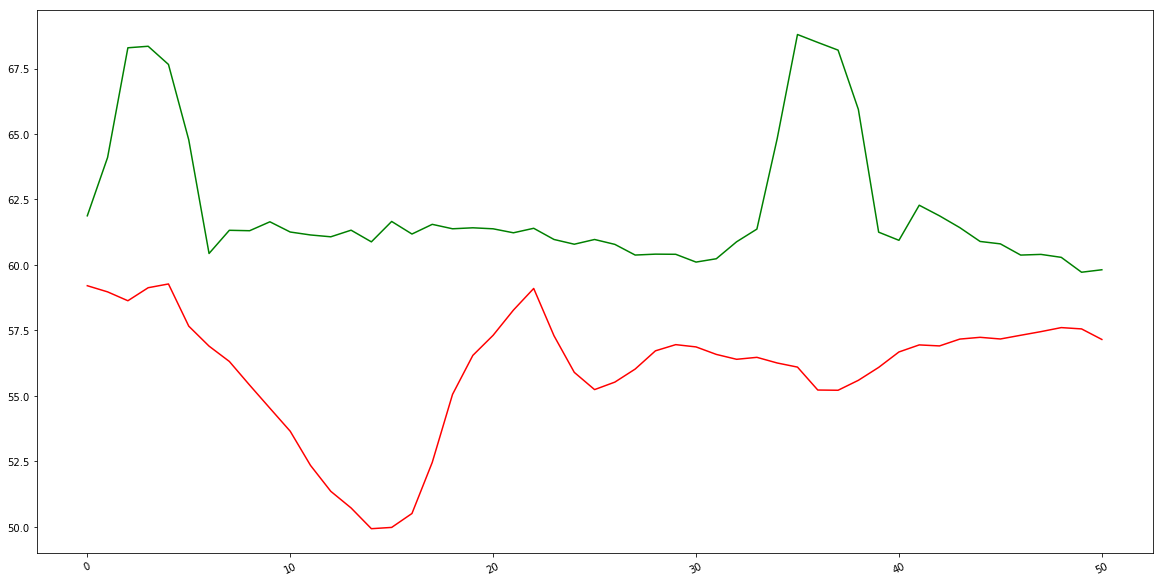

In [83]:
plt.plot(Predictions,color='green')
plt.plot(test_set_1,color='red')
plt.xticks( rotation=25)
plt.show()